In [0]:
import pandas as pd
import numpy as np

# Dataset:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata/downloads/tmdb-5000-movie-dataset.zip/2

from google.colab import files
uploaded = files.upload()

credits = pd.read_csv("tmdb_5000_credits.csv")

movies_incomplete = pd.read_csv("tmdb_5000_movies.csv")

credits: (4803, 4)
movies_incomplete: (4803, 20)


In [0]:
# Shapes of dataframes
print("credits:", credits.shape)
print("movies_incomplete:", movies_incomplete.shape)

credits: (4803, 4)
movies_incomplete: (4803, 20)


In [0]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [0]:
movies_incomplete.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
credits_renamed = credits.rename(index=str, columns={"movie_id": "id"})
movies_dirty = movies_incomplete.merge(credits_renamed, on='id')
movies_dirty.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [0]:
movies_clean= movies_dirty.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])
movies_clean.head()

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# Basic Recommender Systems

Nous recommanderons 4 systèmes de recommandations: 

1/ une liste de films les mieux notés

2/ Une liste de films les plus populaires 

3/ Un mix des 2

4/ Une liste basée sur les résumés

In [0]:
#recherche des moyennes pondérées- On ne se préoccupe que des films ayant obtenus au moins 70% de votes. Utilisation de la formule IMDB
V = movies_clean['vote_count']
R = movies_clean['vote_average']
C = movies_clean['vote_average'].mean()
m = movies_clean['vote_count'].quantile(0.70)

movies_clean['weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)

In [0]:
movies_ranked = movies_clean.sort_values('weighted_average', ascending=False)
movies_ranked[['original_title', 'vote_count', 'vote_average', 'weighted_average', 'popularity']].head()

,original_title,vote_count,vote_average,weighted_average,popularity
1881,The Shawshank Redemption,8205,8.5,8.340775,136.747729
3337,The Godfather,5893,8.4,8.192887,143.659698
662,Fight Club,9413,8.3,8.171648,146.757391
3232,Pulp Fiction,8428,8.3,8.157615,121.463076
65,The Dark Knight,12002,8.2,8.102674,187.322927


*  1er système de recommandation :

Recommandation de 10 films avec les cotes moyennes pondérées les + élevées:


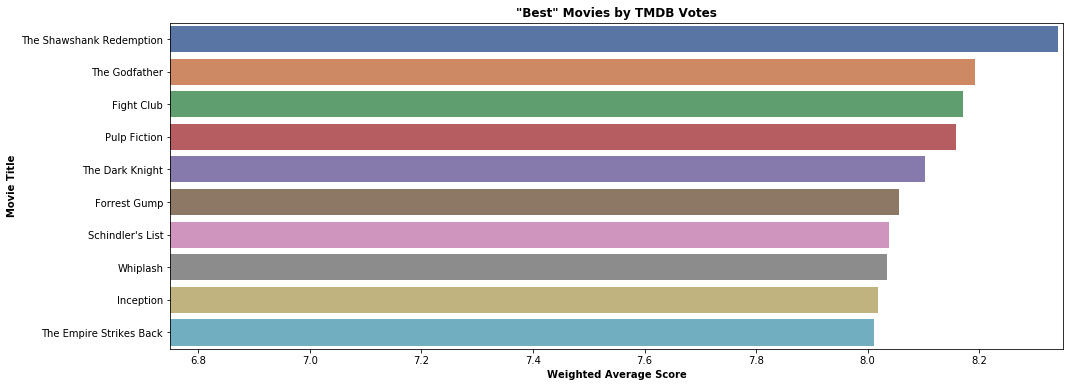

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

wavg = movies_ranked.sort_values('weighted_average', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=wavg['weighted_average'].head(10), y=wavg['original_title'].head(10), data=wavg, palette='deep')

plt.xlim(6.75, 8.35)
plt.title('"Best" Movies by TMDB Votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('best_movies.png')

* 2ème système de recommandation :

Recommandation de 10 films en fonction de leur popularité

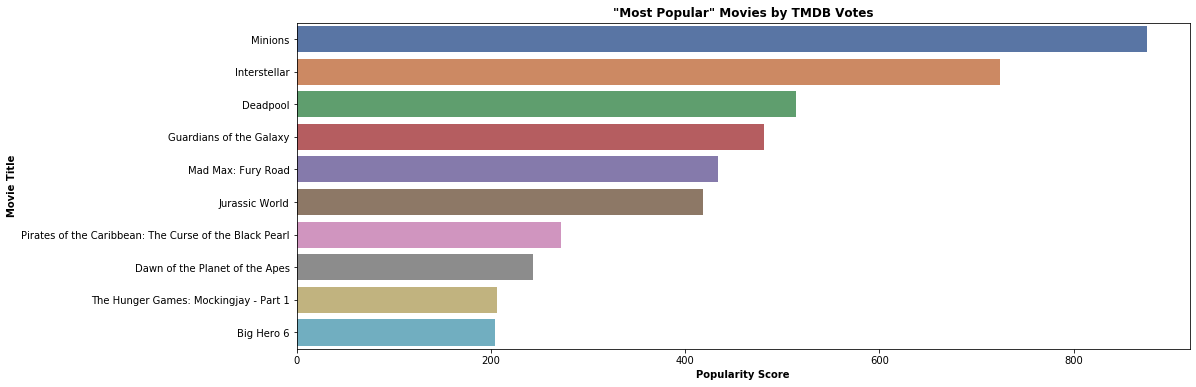

In [0]:
popular = movies_ranked.sort_values('popularity', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=popular['popularity'].head(10), y=popular['original_title'].head(10), data=popular, palette='deep')

plt.title('"Most Popular" Movies by TMDB Votes', weight='bold')
plt.xlabel('Popularity Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('popular_movies.png')

Que se passe t-il si nous combinons les 2 systèmes de recommandations, c'est à dire la recommandation de films en fonction de leur notes moyennes pondérées ET de leurs scores de popularité?

* 3ème Recommandation:

Pour éviter un classement biaisé, nous allons normaliser les valeurs "weighted_average et popularité"; avec répartition 50/50 entre la note moyenne pondérée et les scores de popularité. 


In [0]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
movies_scaled = min_max_scaler.fit_transform(movies_clean[['weighted_average', 'popularity']])
movies_norm = pd.DataFrame(movies_scaled, columns=['weighted_average', 'popularity'])
movies_norm.head()

movies_clean[['norm_weighted_average', 'norm_popularity']] = movies_norm

movies_clean['score'] = movies_clean['norm_weighted_average'] * 0.5 + movies_clean['norm_popularity'] * 0.5
movies_scored = movies_clean.sort_values(['score'], ascending=False)
movies_scored[['original_title', 'norm_weighted_average', 'norm_popularity', 'score']].head(20)

,original_title,norm_weighted_average,norm_popularity,score
95,Interstellar,0.906439,0.827162,0.866801
546,Minions,0.460630,1.000000,0.730315
94,Guardians of the Galaxy,0.851874,0.549462,0.700668
788,Deadpool,0.725217,0.587690,0.656453
127,Mad Max: Fury Road,0.670973,0.495989,0.583481
1881,The Shawshank Redemption,1.000000,0.156179,0.578090
65,The Dark Knight,0.934991,0.213941,0.574466
3865,Whiplash,0.916431,0.219887,0.568159
3337,The Godfather,0.959622,0.164074,0.561848
662,Fight Club,0.953823,0.167611,0.560717


Nous avons maintenant une nouvelle colonne "score" qui prend en compte les 2 systèmes de recommandations, la note moyenne pondérée d'un film et son score de popularité, avec une répartition 50/50 : 

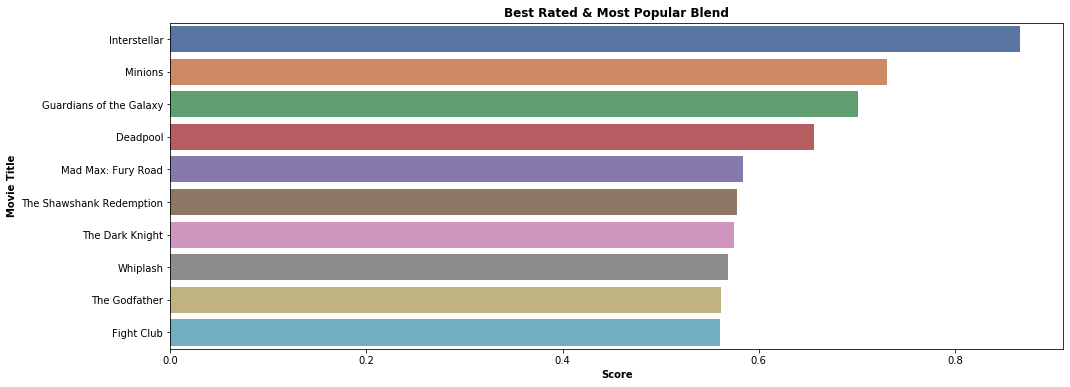

In [0]:
scored = movies_clean.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored['score'].head(10), y=scored['original_title'].head(10), data=scored, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('scored_movies.png')

# Content-Based Filtering
Filtrage basé sur le contenu. 
Nous allons maintenant faire des recommandations basées sur les résumés de l'intrigue du film donnés dans la colonne de vue d'ensemble . Donc, si notre utilisateur nous donne un titre de film, notre objectif est de recommander des films qui partagent des résumés similaires.

Vectorisation de mots et TF-IDF

Avant de commencer l'analyse de résumé, nous devrons convertir les textes dans la colonne de 'vue d'ensemble" en vecteur de mots.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using Abhishek Thakur's arguments for TF-IDF
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Filling NaNs with empty string
movies_clean['overview'] = movies_clean['overview'].fillna('')

# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(movies_clean['overview'])

tfv_matrix.shape

(4803, 10417)

Environ 10 000 mots uniques ont été utilisés dans les résumés de l'intrigue pour décrire nos 5 000 films.
* Calcul des scores de similarité

Cette métrique nous permettra de sélectionner des films avec des résumés similaires soumis par l'utilisateur.

In [0]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

# Reverse mapping of indices and movie titles
indices = pd.Series(movies_clean.index, index=movies_clean['original_title']).drop_duplicates()

# Credit to Ibtesam Ahmed for the skeleton code
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return movies_clean['original_title'].iloc[movie_indices]

Alors maintenant que nous avons construit notre système de filtrage basé sur le contenu, testons-le avec notre préféré intemporel, Spy Kids :



In [0]:
# Testing our content-based recommendation system with the seminal film Spy Kids
give_rec('Spy Kids')

1302    Spy Kids 2: The Island of Lost Dreams
1155                  Spy Kids 3-D: Game Over
1769      Spy Kids: All the Time in the World
3359                              In Too Deep
1631                                 Mr. 3000
4044                               Go for It!
339                           The Incredibles
1081                       Revolutionary Road
1825                Jimmy Neutron: Boy Genius
2441                   Escobar: Paradise Lost
Name: original_title, dtype: object

Notre système de recommandations nous a donc donné quelques choix concernant Spy Kids , mais quelques faux pas tels que In Too Deep et Escobar: Paradise Lost se sont glissés.
